In [2]:
import sys
!{sys.executable} -m pip install -q scikit-learn cvxpy osqp


In [4]:
import numpy as np
import pandas as pd
import cvxpy as cp
from sklearn.covariance import LedoitWolf

# --- Load returns ---
rets = pd.read_csv("/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/data_processed/returns_log.csv", index_col=0, parse_dates=True).sort_index()
tickers = rets.columns
N = len(tickers)

# Monthly rebalance dates
rebalance_dates = rets.groupby([rets.index.year, rets.index.month]).head(1).index

# ---- Rolling PCA (correlation) from Week 3 (reuse your earlier function if you have it) ----
def rolling_pca_corr(rets, rebalance_dates, W=252, K=5, orient_ticker="SPY"):
    tickers = rets.columns
    N = len(tickers)
    dates_used, V_list = [], []
    prev_VK = None
    for T in rebalance_dates:
        loc = rets.index.get_indexer([T])[0]
        if loc < W:
            continue
        window = rets.iloc[loc-W:loc]
        X = window - window.mean(axis=0)
        s = X.std(axis=0, ddof=1).replace(0, np.nan)
        Z = (X / s).values
        C = (Z.T @ Z) / (len(window) - 1)

        w, V = np.linalg.eigh(C)
        idx = np.argsort(w)[::-1]
        V = V[:, idx]

        # align first K signs to previous
        VK = V[:, :K].copy()
        if prev_VK is not None:
            for k in range(K):
                if np.dot(VK[:, k], prev_VK[:, k]) < 0:
                    VK[:, k] *= -1
            V[:, :K] = VK
        prev_VK = V[:, :K].copy()

        # orient PC1 so SPY loading positive (consistency)
        if orient_ticker in tickers:
            j = tickers.get_loc(orient_ticker)
            if V[j, 0] < 0:
                V[:, 0] *= -1

        dates_used.append(T)
        V_list.append(V)
    return pd.DatetimeIndex(dates_used), V_list

# ---- Backtest function (same structure as Week 3) ----
def backtest_from_rebalance_weights(rets_log, w_reb, cost_per_turnover=0.001):
    w_daily = w_reb.reindex(rets_log.index).ffill()
    port_log = (w_daily * rets_log).sum(axis=1)
    gross_simple = np.exp(port_log) - 1

    w_prev = w_reb.shift(1)
    turnover = (w_reb - w_prev).abs().sum(axis=1)
    turnover.iloc[0] = w_reb.iloc[0].abs().sum()

    gross_lev = w_reb.abs().sum(axis=1)

    wealth_gross = (1 + gross_simple).cumprod()
    wealth_net = []
    W = 1.0
    reb_set = set(w_reb.index)
    for t in gross_simple.index:
        W *= (1 + gross_simple.loc[t])
        if t in reb_set:
            W *= (1 - cost_per_turnover * turnover.loc[t])
        wealth_net.append(W)

    out = pd.DataFrame({
        "gross_simple_ret": gross_simple,
        "wealth_gross": wealth_gross,
        "wealth_net": pd.Series(wealth_net, index=gross_simple.index),
        "turnover": turnover.reindex(gross_simple.index),
        "gross_leverage": gross_lev.reindex(gross_simple.index),
    })
    return out

def perf_metrics(simple_rets):
    T = len(simple_rets)
    wealth = (1 + simple_rets).cumprod()
    cagr = wealth.iloc[-1]**(252/T) - 1
    vol = simple_rets.std() * np.sqrt(252)
    sharpe = (simple_rets.mean() * 252) / vol if vol > 0 else np.nan
    dd = wealth / wealth.cummax() - 1
    return cagr, vol, sharpe, dd.min()

# ---- Week 4: stabilized FNMV builder ----
def build_factor_neutral_minvar_stable(
    rets,
    dates_used,
    V_list,
    W=252,
    K_neutral=2,
    Lmax=2.5,
    Lmax_grid=(2.5, 3.0, 3.5, 4.0, 5.0),
    solver_order=("OSQP", "ECOS", "SCS"),
    jitter=1e-8,
    verbose_failures=True
):
    """
    Builds factor-neutral min-var with:
      - LedoitWolf covariance
      - constraints: sum(w)=1, VK'w=0, ||w||_1 <= Lmax
      - robustness: PSD wrapping, solver fallback, Lmax escalation if infeasible

    Returns:
      w_df: weights at each rebalance date
      used_caps: Series of the cap that was actually used at each date
    """
    tickers = rets.columns
    N = len(tickers)

    w_rows = []
    used_caps = []

    for T, V in zip(dates_used, V_list):
        loc = rets.index.get_indexer([T])[0]
        window = rets.iloc[loc-W:loc]
        X = (window - window.mean(axis=0)).values

        Sigma = LedoitWolf().fit(X).covariance_
        # numerical hygiene
        Sigma = 0.5 * (Sigma + Sigma.T) + jitter * np.eye(N)
        Sigma_psd = cp.psd_wrap(Sigma)

        VK = V[:, :K_neutral]

        solved = False
        last_status = None

        for cap in Lmax_grid if Lmax not in Lmax_grid else Lmax_grid:
            # enforce starting at requested Lmax if it’s in the grid; else just use the grid as given
            if cap < Lmax:
                continue

            w = cp.Variable(N)
            constraints = [
                cp.sum(w) == 1,
                VK.T @ w == np.zeros(K_neutral),
                cp.norm1(w) <= cap
            ]
            objective = cp.Minimize(0.5 * cp.quad_form(w, Sigma_psd))
            prob = cp.Problem(objective, constraints)

            for sol in solver_order:
                try:
                    if sol == "OSQP":
                        prob.solve(solver=cp.OSQP, verbose=False, eps_abs=1e-6, eps_rel=1e-6, max_iter=200000)
                    elif sol == "ECOS":
                        prob.solve(solver=cp.ECOS, verbose=False)
                    elif sol == "SCS":
                        prob.solve(solver=cp.SCS, verbose=False, max_iters=200000)
                    else:
                        continue
                except Exception:
                    continue

                last_status = prob.status
                if prob.status in ("optimal", "optimal_inaccurate") and w.value is not None:
                    w_rows.append(w.value)
                    used_caps.append(cap)
                    solved = True
                    break

            if solved:
                break

        if not solved:
            # Diagnostic: try without the L1 cap to see what gross leverage is "needed"
            w_unc = cp.Variable(N)
            prob_unc = cp.Problem(
                cp.Minimize(0.5 * cp.quad_form(w_unc, Sigma_psd)),
                [cp.sum(w_unc) == 1, VK.T @ w_unc == np.zeros(K_neutral)]
            )
            try:
                prob_unc.solve(solver=cp.OSQP, verbose=False, max_iter=200000)
                l1_needed = float(np.sum(np.abs(w_unc.value))) if w_unc.value is not None else np.nan
            except Exception:
                l1_needed = np.nan

            if verbose_failures:
                print(f"[FAIL] {T.date()} status={last_status}, requested Lmax={Lmax}, "
                      f"tried caps={list(Lmax_grid)}; unconstrained L1≈{l1_needed}")

            raise RuntimeError(
                f"Optimization failed at {T}. Likely infeasible at your caps or solver issues. "
                f"Try larger Lmax_grid or reduce K_neutral."
            )

    w_df = pd.DataFrame(w_rows, index=dates_used, columns=tickers)
    used_caps = pd.Series(used_caps, index=dates_used, name="used_Lmax")
    return w_df, used_caps


# ---- Run it ----
W = 252
K_track = 5
K_neutral = 2
Lmax = 2.5
COST = 0.001

dates_used, V_list = rolling_pca_corr(rets, rebalance_dates, W=W, K=K_track, orient_ticker="SPY")

w_fnmv_stable, used_caps = build_factor_neutral_minvar_stable(
    rets, dates_used, V_list,
    W=252, K_neutral=2, Lmax=Lmax,
    Lmax_grid=(2.5, 3.0, 3.5, 4.0, 5.0, 6.0),
    solver_order=("OSQP","ECOS","SCS"),
    jitter=1e-8
)

print("Caps used (value counts):")
print(used_caps.value_counts().sort_index())

bt_fnmv_stable = backtest_from_rebalance_weights(rets, w_fnmv_stable, cost_per_turnover=COST)

# Summarize
gross = bt_fnmv_stable["gross_simple_ret"]
net = bt_fnmv_stable["wealth_net"].pct_change().fillna(0.0)

cagr_g, vol_g, sh_g, mdd_g = perf_metrics(gross)
cagr_n, vol_n, sh_n, mdd_n = perf_metrics(net)

avg_to = bt_fnmv_stable["turnover"].dropna().mean()
avg_lev = bt_fnmv_stable["gross_leverage"].dropna().mean()

print("Stable FNMV (LW + L1 cap)")
print("CAGR gross/net:", cagr_g, cagr_n)
print("Sharpe gross/net:", sh_g, sh_n)
print("MaxDD gross/net:", mdd_g, mdd_n)
print("AvgTurnover:", avg_to, "AvgGrossLev:", avg_lev)

w_fnmv_stable.to_csv("/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/csvweek4_outputs_weights_fnmv_stable.csv")


/var/folders/h9/mp3w6nh50fx04f637tlzfwyc0000gn/T/ipykernel_51778/2683409710.py:28: RuntimeWarning: divide by zero encountered in matmul
  C = (Z.T @ Z) / (len(window) - 1)
/var/folders/h9/mp3w6nh50fx04f637tlzfwyc0000gn/T/ipykernel_51778/2683409710.py:28: RuntimeWarning: overflow encountered in matmul
  C = (Z.T @ Z) / (len(window) - 1)
/var/folders/h9/mp3w6nh50fx04f637tlzfwyc0000gn/T/ipykernel_51778/2683409710.py:28: RuntimeWarning: invalid value encountered in matmul
  C = (Z.T @ Z) / (len(window) - 1)
/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: divide by zero encountered in matmul
  B = (u * psigma_diag) @ u.conj().T
/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: overflow encountered in matmul
  B = (u * psigma_diag) @ u.conj().T
/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: invalid value encountered in matmul
 

Caps used (value counts):
used_Lmax
2.5    96
3.0    32
3.5     3
Name: count, dtype: int64
Stable FNMV (LW + L1 cap)
CAGR gross/net: 0.036722479134769115 0.02368493874223776
Sharpe gross/net: 0.32388001721628984 0.2352755904095396
MaxDD gross/net: -0.2556298226705648 -0.29703498200209755
AvgTurnover: 1.1519506017137147 AvgGrossLev: 2.6450579003982946


/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: divide by zero encountered in matmul
  B = (u * psigma_diag) @ u.conj().T
/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: overflow encountered in matmul
  B = (u * psigma_diag) @ u.conj().T
/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: invalid value encountered in matmul
  B = (u * psigma_diag) @ u.conj().T
/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: divide by zero encountered in matmul
  B = (u * psigma_diag) @ u.conj().T
/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: overflow encountered in matmul
  B = (u * psigma_diag) @ u.conj().T
/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: invalid value encou

In [7]:
results = []
for K_neutral in [1, 2]:
    for Lmax in [1.5, 2.0, 2.5, 3.0]:
        w_stable, used_caps = build_factor_neutral_minvar_stable(
            rets, dates_used, V_list,
            W=W, K_neutral=K_neutral, Lmax=Lmax,
            Lmax_grid=(Lmax, 3.5, 4.0, 5.0, 6.0),   # start at requested Lmax then allow escalation
            solver_order=("OSQP","ECOS","SCS")
        )

        bt = backtest_from_rebalance_weights(rets, w_stable, cost_per_turnover=COST)

        gross = bt["gross_simple_ret"]
        net = bt["wealth_net"].pct_change().fillna(0.0)

        cagr_g, vol_g, sh_g, mdd_g = perf_metrics(gross)
        cagr_n, vol_n, sh_n, mdd_n = perf_metrics(net)

        results.append({
            "K_neutral": K_neutral,
            "Lmax_requested": Lmax,
            "Lmax_used_mode": float(used_caps.mode().iloc[0]),
            "Lmax_used_max": float(used_caps.max()),
            "CAGR_net": cagr_n,
            "Sharpe_net": sh_n,
            "MaxDD_net": mdd_n,
            "AvgTurnover": bt["turnover"].dropna().mean(),
            "AvgGrossLev": bt["gross_leverage"].dropna().mean(),
        })

grid = pd.DataFrame(results).sort_values(["K_neutral","Lmax_requested"])
grid.to_csv("/Users/jacobhahn/Desktop/QUANT PROJECT WINTER 2025/week4_outputs_robustness_grid.csv", index=False)
grid



/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: divide by zero encountered in matmul
  B = (u * psigma_diag) @ u.conj().T
/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: overflow encountered in matmul
  B = (u * psigma_diag) @ u.conj().T
/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: invalid value encountered in matmul
  B = (u * psigma_diag) @ u.conj().T
/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: divide by zero encountered in matmul
  B = (u * psigma_diag) @ u.conj().T
/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: overflow encountered in matmul
  B = (u * psigma_diag) @ u.conj().T
/Users/jacobhahn/path/to/venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1715: RuntimeWarning: invalid value encou

,K_neutral,Lmax_requested,Lmax_used_mode,Lmax_used_max,CAGR_net,Sharpe_net,MaxDD_net,AvgTurnover,AvgGrossLev
0,1,1.5,1.5,3.5,0.013895,0.327024,-0.121792,0.556032,1.759090
1,1,2.0,2.0,3.5,0.012774,0.360497,-0.114263,0.454026,1.943973
2,1,2.5,2.5,2.5,0.012565,0.367263,-0.114263,0.445659,2.057578
3,1,3.0,3.0,3.0,0.013092,0.427187,-0.114263,0.449255,2.189735
4,2,1.5,3.5,3.5,0.020018,0.266125,-0.178723,0.981604,3.469465
5,2,2.0,3.5,3.5,0.046132,0.449133,-0.236478,1.201419,2.973282
6,2,2.5,2.5,3.5,0.019846,0.213259,-0.291503,1.260353,2.767195
7,2,3.0,3.0,3.5,0.026464,0.293503,-0.194706,0.922711,3.011453


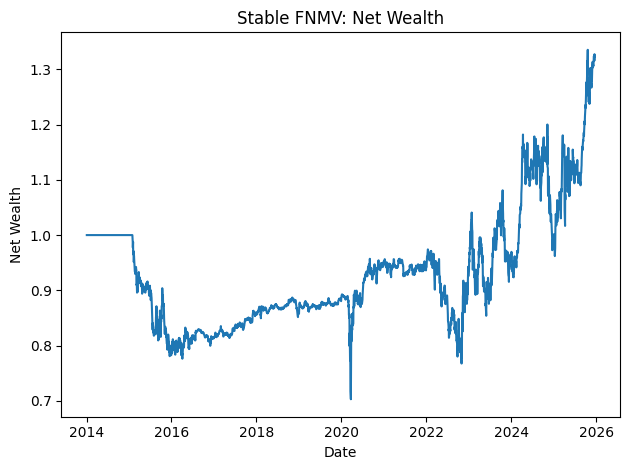

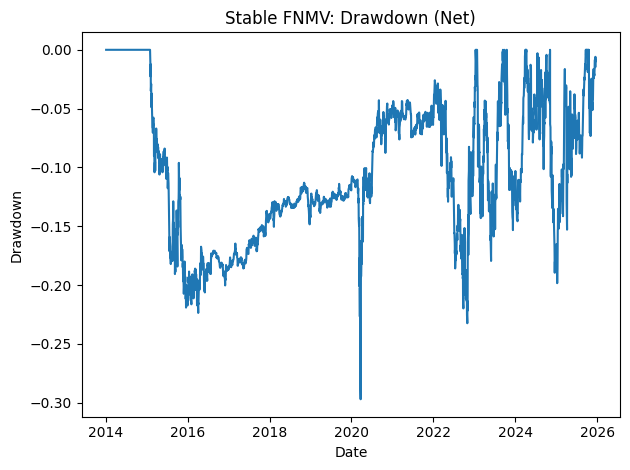

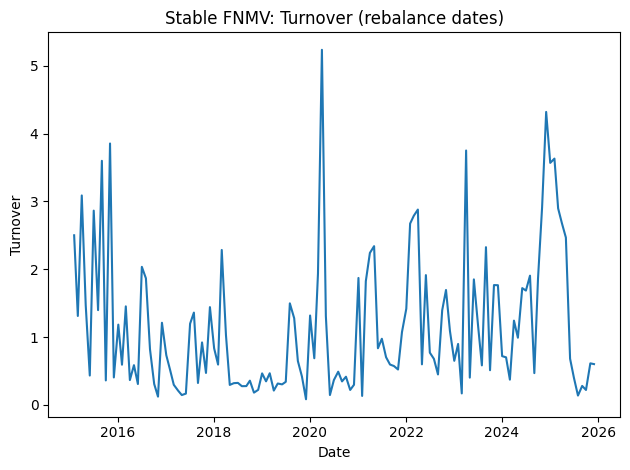

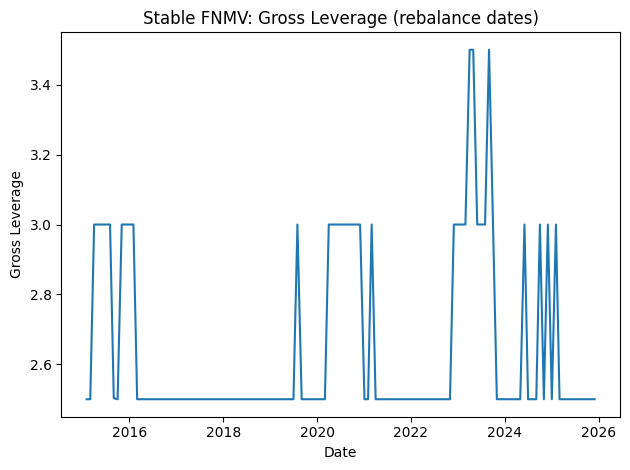

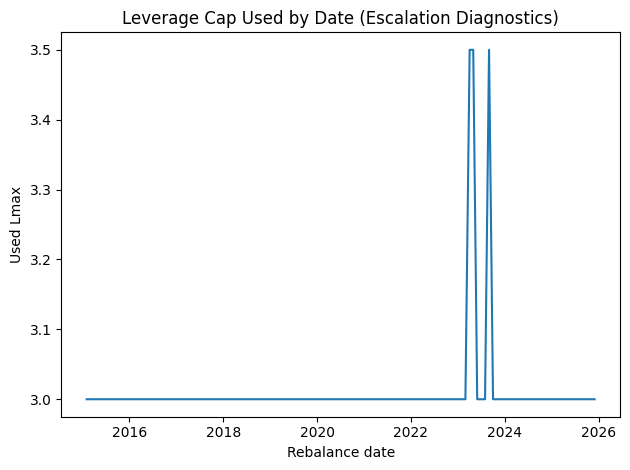

In [8]:
import matplotlib.pyplot as plt

def plot_series(s, title, fname, ylabel):
    plt.figure()
    plt.plot(s)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(f"figures/{fname}")
    plt.show()

# Net wealth & drawdown for stabilized FNMV
plot_series(bt_fnmv_stable["wealth_net"], "Stable FNMV: Net Wealth", "week4_wealth_fnmv_stable.png", "Net Wealth")

w = bt_fnmv_stable["wealth_net"]
dd = w / w.cummax() - 1
plot_series(dd, "Stable FNMV: Drawdown (Net)", "week4_dd_fnmv_stable.png", "Drawdown")

# Turnover and leverage over time (rebalance dates)
plot_series(bt_fnmv_stable["turnover"].dropna(), "Stable FNMV: Turnover (rebalance dates)", "week4_turnover_fnmv_stable.png", "Turnover")
plot_series(bt_fnmv_stable["gross_leverage"].dropna(), "Stable FNMV: Gross Leverage (rebalance dates)", "week4_grosslev_fnmv_stable.png", "Gross Leverage")


plt.figure()
plt.plot(used_caps.index, used_caps.values)
plt.title("Leverage Cap Used by Date (Escalation Diagnostics)")
plt.xlabel("Rebalance date")
plt.ylabel("Used Lmax")
plt.tight_layout()
plt.savefig("figures/week4_used_Lmax_over_time.png")
plt.show()
